# Metody jądrowe (kernel methods)

## Konfiguracja

Użyjemy bardzo standardowych narzędzi, tych samych, co na laboratorium 1.

In [ ]:
!pip install numpy scipy pandas matplotlib scikit-learn missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

## Duży zbiór danych do klasyfikacji

Użyjemy najpierw bioinformatycznego zbioru danych [Cod-RNA](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#cod-rna). Pochodzi on z artykułu ([link do wersji Open Access](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173)):

> Uzilov, Andrew V., Joshua M. Keegan, and David H. Mathews. *"Detection of non-coding RNAs on the basis of predicted secondary structure formation free energy change."* BMC bioinformatics 7.1 (2006): 1-30. [link](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173)

[Centralny dogmat biologii molekularnej (central dogma of molecular biology)](https://en.wikipedia.org/wiki/Central_dogma_of_molecular_biology) mówi, że przepływ informacji genetycznej przebiega z DNA przez RNA do białek. Innymi słowy, DNA zapisuje informację biologiczną, którą potem koduje RNA, z którego są syntezowane białka.

W praktyce nie każde DNA i RNA koduje informacje. Kodujące DNA to zaledwie ok. 1-2% ludzkiego genomu, a reszta pełni różne role, głównie regulacyjne. W szczególności [niekodujące RNA (non-coding RNA, ncRNA)](https://en.wikipedia.org/wiki/Non-coding_RNA) pełni wiele różnych zadań, na przykład:
- budują rybosomy odpowiadające za syntezę białek ([rRNA](https://en.wikipedia.org/wiki/Ribosomal_RNA))
- transportują informację genetyczną ([tRNA](https://en.wikipedia.org/wiki/Transfer_RNA))
- regulują ekspresję genów ([lncRNA](https://en.wikipedia.org/wiki/Long_non-coding_RNA))

Nie są znane wszystkie funkcje niekodującego RNA, więc jest to aktywne pole badań. Najpierw trzeba jednak sprawdzić, czy dane RNA w ogóle jest kodujące, czy nie. Taka klasyfikacja jest nieoczywista, i też stanowi pole badań w bioinformatyce. Niektóre hipotezy wskazują, że struktura drugorzędowa RNA ma tutaj znacznie.

Struktura pierwszorzędowa kwasu nukleinowego (DNA lub RNA) to po prostu liniowa sekwencja nukleotydów, np. ACCUUGCAUC. Struktura drugorzędowa oznacza ułożenie par nukleotydów (np. G-C, A-U) jednego lub dwóch łańcuchów.  Dla DNA to typowo podwójna helisa, natomiast RNA tworzy już bardzo bogate i złożone struktury. Przewidywanie struktury wyższego rzędu to typowe zadanie ML w bioinformatyce, bo sprawdzanie tego eksperymentalnie jest bardzo drogie.

![nucleic_acid_structures.png](nucleic_acid_structures.png)

Przykładem algorytmu przewidującego strukturę drugorzędową jest [Dynalign](https://www.sciencedirect.com/science/article/abs/pii/S0022283601953513). Opiera się on na obserwacji, że niektóre struktury drugorzędowe RNA są bardziej stabilne od innych. Struktury o niższej energii są, zgodnie z zasadami termodynamiki, wolniejsze, a zatem stabilniejsze i bardziej prawdopodobne. Algorytm ten dodatkowo realizuje **dopasowanie sekwencji (sequence alignment)**, czyli takie "przyłożenie" do siebie sekwencji RNA, żeby jak najwięcej par pasowało do siebie. Wejściem do niego są 2 sekwencje RNA, a wyjściem ilość wolnej energii w optymalnej strukturze drugorzędowej RNA - im mniejsza, tym stabilniejsza jest struktura.

Artykuł, z którego pochodzi nasz zbiór danych, zaproponował zastosowanie ML do klasyfikacji, czy dwie sekwencje RNA stanowią niekodujące RNA (ncRNA), czy też nie. Zbiór treningowy zbudowano z blisko 60 tysięcy par sekwencji RNA pochodzących z sekwencjonowania genomu bakterii *Escherichia coli* oraz *Salmonella enterica serovar Typhi (Salmonella typhi)*. Klasą pozytywną jest niekodujące RNA (5S rRNA albo tRNA), a negatywną losowo przemieszane nukleotydy z prawdziwej pary (istnieją do tego algorytmy tzw. sequence shuffling). Klasy są w stosunku 1:2, więc mamy klasyfikację lekko niezbalansowaną. Analogicznie stworzono zbiór testowy o wielkości nieco ponad 270 tysięcy par.

Jako cech użyto:
- wartości z algorytmu Dynalign
- długości krótszej sekwencji
- częstotliwości zasad azotowych A/U/C w sekwencji 1 (3 cechy)
- częstotliwości zasad azotowych A/U/C w sekwencji 2 (3 cechy)

Mamy zatem klasyfikację binarną, umiarkowanie niezbalansowaną, i 8 cech numerycznych. Jako metryk autorzy używają precyzji, czułości, krzywych ROC oraz wartości AUROC.

My dla uproszczenia użyjemy F1-score, czyli średniej harmonicznej precyzji (precision) i czułości (recall). Obliczanie prawdopodobieństw w SVMach jest kosztowne i daje raczej niskiej jakości predykcje prawdopodobieństw, więc AUROC nie jest dla nich zbyt wygodną metryką.

Oryginalny zbiór jest w formacie `svmlight`, z którego korzystają biblioteki LibSVM i Liblinear. Są one standardowymi implementacjami SVMów. Sam ten format danych jest jednak tekstowy i zajmuje bardzo dużo miejsca, dlatego w tym repozytorium jest już przetworzony do formatu Parquet. Wczytamy teraz dane.

Później trzeba dokonać normalizacji cech, tak jak zawsze w SVMach. Tak jak autorzy, wykonamy skalowanie min-max do zakresu [-1, 1].

**Zadanie 1 (0.5 punktu)**

1. Wczytaj dane treningowe z plików `cod_rna_train.parquet` oraz `cod_rna_test.parquet`.
2. Wyodrębnij kolumnę `y` do osobnych zmiennych `y_train` oraz `y_test`.
3. Dokonaj skalowania danych do zakresu [-1, 1], tworząc tablice `X_train_scaled` oraz `X_test_scaled`.

In [ ]:
df_train = pd.read_parquet('cod_rna_train.parquet')
df_test = pd.read_parquet('cod_rna_test.parquet')

y_train = df_train['y']
y_test = df_test['y']

df_train.drop('y', axis=1, inplace=True)
df_test.drop('y', axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(df_train)
X_test_scaled = scaler.transform(df_test)

Skoro dane są gotowe, to wytrenujmy nasz pierwszy klasyfikator - liniowy SVM.

W Scikit-learn funkcja kosztu (`loss`) to albo typowy hinge loss, albo squared hinge loss, czyli po prostu podniesiona do kwadratu. Wartość domyślna to `"squared_hinge"` - żeby dostać "typowego" SVMa, trzeba to zmienić. Jest różniczkowalna i mocniej kara duże błędy, ale jest też bardziej podatna na outliery. Dla zainteresowanych: [przystępny tutorial](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-hinge-squared-hinge-loss-with-keras.md) oraz artykuł naukowy:

C.P. Lee, and C.J. Lin. *"A study on L2-loss (squared hinge-loss) multiclass SVM."* Neural computation 25.5 (2013): 1302-1323.

Dodatkowo domyślna liczba iteracji solwera (1000) jest często dość niska, szczególnie przy dużych zbiorach. Zwiększymy to od razu, żeby mieć mniej warningów. Powyżej 10 tysięcy iteracji warningami można się już zazwyczaj nie przejmować.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC


clf_linear_svc = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0
)
clf_linear_svc.fit(X_train_scaled, y_train)

y_pred = clf_linear_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 93.03%


## Liniowy SVM

**Zadanie 2 (0.5 punktu)**

Wytrenuj regresję logistyczną jako nasz **model baseline'owy**. Nasze bardziej złożone modele SVM muszą być od niego lepsze, żeby był w ogóle sens je rozważać.

Użyj regularyzacji L2. Dokonaj tuningu siły regularyzacji (100 wartości) za pomocą 5-krotnej walidacji skrośnej. Jako metryki do tuningu użyj F1-score.

Użyj zbalansowanych wag klas. W razie potrzeby zwiększ maksymalną liczbę iteracji solwera. Może się przydać `n_jobs`. Pamiętaj o ustawieniu `random_state=0`.

Sprawdź wyniki algorytmu na zbiorze testowym.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

baseline = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=0,
    penalty='l2',
    n_jobs=-1)

param_grid = {
    'C': np.logspace(-3, 3, num=100)
    }

grid_search = GridSearchCV(baseline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(f1_score))
grid_search.fit(X_train_scaled, y_train)

y_pred = grid_search.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(grid_search.best_params_)

F1-score: 93.27%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

baseline = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=0,
    penalty='l2',
    n_jobs=-1)

param_grid = {
    'C': np.logspace(-3, 3, num=100)
    }

grid_search_reg = GridSearchCV(baseline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(f1_score))
grid_search_reg.fit(X_train_scaled, y_train)

y_pred_reg = grid_search_reg.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred_reg):.2f}%")
print(grid_search_reg.best_params_)

F1-score: 93.27%
{'C': 2.1544346900318843}


Nasz SVM bez żadnego tuningu jest zasadniczo tak dobry, jak regresja logistyczna z tuningiem - całkiem nieźle. No ale czas teraz na tuning samego SVMa.

Najpierw warto wiedzieć jeszcze parę rzeczy o implementacji użytej w Scikit-learn, korzystającej pod spodem z Liblinear.

Argument `dual` wyznacza, czy skorzystać z postaci primal, czy dual. Jeżeli liczba próbek jest znacznie większa od liczby cech, albo ogółem mamy sporo próbek, to lepiej użyć primal `dual=False`. Niestety, wtedy mamy do dyspozycji tylko funkcję kosztu `squared_hinge`.

SVM jest stricte jednowątkowy (sekwencyjny), więc równoległość można wykorzystać przy tuningu hiperparametrów. Zdecydowanie warto użyć tu `n_jobs=-1`.

**Uwaga:** jako że osobne joby są tworzone jako osobne procesy, to wyłączenie `ConvergenceWarning` jest nietrywialne, a czasem niemożliwe. Sugeruję to po prostu zignorować.

**Zadanie 3 (1 punkt)**

Dokonaj tuningu hiperparametru `C` liniowego SVM. Użyj 5-krotnej walidacji skrośnej, wybierając model o najwyższym F1-score. Użyj zbalansowanych wag klas i funkcji kosztu hinge loss. Pamiętaj o stałym `random_state`.

Zastosuj iteracyjne zagęszczanie siatki. Najpierw sprawdź wartości z zakresu `[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]` i znajdź optymalną wartość `C`. Następnie wedle własnego uznania zagęść siatkę wokół znalezionego optymalnego C. Może się przydać `np.linspace()` albo `list(range())`. Jeżeli w takiej operacji wychodzi optymalne `C` na granicy (najmniejsze albo największe możliwe), to warto sprawdzić większe wartości niż dotychczas rozważane. Powtórz takie działanie 2-3 razy. W praktyce jednak `C` większe niż kilkaset nie ma sensu w kontekście SVMów.

Wypisz ostatecznę znalezioną optymalną wartość odwrotności siły optymalizacji `C`. Sprawdź wynik na zbiorze testowym. Czy udało się przebić baseline?

In [ ]:
param_grid = {
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
}

clf_linear_svc = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0,
    class_weight='balanced'
)

grid_search = GridSearchCV(clf_linear_svc, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
print("Best C:", grid_search.best_params_['C'])

Best C: 100.0


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
best_C = grid_search.best_params_['C']
param_grid = {
    'C': np.linspace(best_C/10, best_C*10, num=10).tolist()
}

grid_search = GridSearchCV(clf_linear_svc, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best C:", grid_search.best_params_['C'])

Best C: 1000.0


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
param_grid = {
    'C': np.linspace(100, 1000, num=5).tolist()
}
grid_search = GridSearchCV(clf_linear_svc, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best C:", grid_search.best_params_['C'])

Best C: 550.0


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
param_grid = {
    'C': np.linspace(500, 600, num=5).tolist()
}

grid_search = GridSearchCV(clf_linear_svc, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best C:", grid_search.best_params_['C'])

Best C: 550.0


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
y_pred = grid_search.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 93.30%


Najlepszą wartością okazało się 550 - dwukrotnie zostało wybrane z otoczenia więc zakładam je jako ostateczne.

Baseline udało się przebić o 0,03 % więc nie dużo, ale w przeciwieństwie do modelu bez tuningu, ten jest już lepszy a nie gorszy od regresji.


Może się to jeszcze uda poprawić - w końcu w artykule autorzy używali kernel SVM, a nie liniowego!

## Kernel SVM

Kernel SVM w Scikit-learn jest implementowany w klasie `SVC`. Wypróbujmy podstawową wersję, bez tuningu hiperparametrów. Przy okazji wiemy, że złożoność kernel SVM to co najmniej $O(n^2)$ - zobaczmy, ile to zajmuje w praktyce.

Warto zawsze ustawić nieco wyższą wartość `cache_size` niż domyślna. Jest to ilość MB na cache'owanie obliczonych wartości kerneli. Warto jednak uważać na zbyt duże wartości:
- wartości ponad 2000 mogą [powodować problemy przez buga w LibSVM](https://github.com/scikit-learn/scikit-learn/issues/8012)
- sama alokacja dużej ilości pamięci (ciągłej!) może zajmować dużo czasu
- nie wszystkie wartości kerneli będą używane często, więc nie wszystkie jest sens cache'ować

In [ ]:
from time import time
from sklearn.svm import SVC


clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0
)
start_time = time()
clf_kernel_svc.fit(X_train_scaled, y_train)
end_time = time()
training_time = end_time - start_time

y_pred = clf_kernel_svc.predict(X_test_scaled)

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {training_time} s")

F1-score: 94.92%
Training time: 48.918612003326416 s


Wynik jest ewidentnie lepszy, bez żadnego tuningu! Zajmuje to jednak sporo czasu. Ale nasz zbiór treningowy to ok. 60 tysięcy, a testowy 270 tysięcy - może to predykcja tyle zajmuje, a nie sam trening?

**Zadanie 4 (1 punkt)**

1. Sprawdź liczbę support vectors dla liniowego i kernel SVM. Sprawdź, jaki procent wszystkich punktów one stanowią. Czy rzadkość (sparsity) została osiągnięta? Może się przydać [ten przykład](https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html), żeby zliczyć support vectors dla liniowego SVM (`X` to u nas `X_train_scaled`).
2. Porównaj czas predykcji na zbiorze testowym dla regresji logistycznej, liniowego SVM i kernel SVM. Uwzględniając rozmiar zbioru testowego, czy twoim zdaniem to dużo?

In [ ]:
clf_linear_svc = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0,
    class_weight='balanced',
    C=550.0
)

clf_linear_svc.fit(X_train_scaled,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=550.0, class_weight='balanced', loss='hinge', max_iter=10000,
          random_state=0)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

decision_function = clf_linear_svc.decision_function(X_train_scaled)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train_scaled[support_vector_indices]

print("for linear SVM:")
print(len(support_vectors)/len(X_train_scaled) * 100, "%")
print(len(support_vectors))


decision_function = clf_kernel_svc.decision_function(X_train_scaled)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train_scaled[support_vector_indices]

print("for kernel SVM")
print(len(support_vectors)/len(X_train_scaled) * 100, "%")
print(len(support_vectors))


for linear SVM:
14.284034601494918 %
8504
for kernel SVM
14.191651969429747 %
8449


In [ ]:
start_time = time()
grid_search_reg.predict(X_test_scaled)
end_time = time()
training_time = end_time - start_time
print(f"Regression time: {training_time} s")

start_time = time()
clf_linear_svc.predict(X_test_scaled)
end_time = time()
training_time = end_time - start_time
print(f"Linear svm time: {training_time} s")

start_time = time()
clf_kernel_svc.predict(X_test_scaled)
end_time = time()
training_time = end_time - start_time
print(f"Kernel svm time: {training_time} s")


Regression time: 0.01743483543395996 s
Linear svm time: 0.009474992752075195 s
Kernel svm time: 160.2133285999298 s


Nie została osiągnięta, bo ponad 14% to sporo.
Z kolei czas predykcji około 2,5 minuty to nie dużo biorąc pod uwagę bardzo duży zbiór testowy.

Taki zbiór jest już dość ekstremalny dla kernel SVM. Tego algorytmu w praktyce nie stosuje się wprost dla zbiorów wielkości dziesiątek tysięcy próbek treningowych, bo byłoby to zbyt wolne. Można tu natomiast zastosować podobną sztuczkę, co z kNN i ANN, czyli aproksymować - w tym wypadku macierz kerneli. Dotyczy tego zadanie dodatkowe.

Dodatkowo implementacja ze Scikit-learn potrafi być zaskakująco wolna. W praktyce LibSVM, użyty jako [samodzielna biblioteka](https://pypi.org/project/libsvm-official/), potrafi być o wiele szybszy. Ma za to dużo brzydszy interfejs.

W praktyce kernel SVM jest używany najczęściej, kiedy mamy mało danych i trzeba bardzo dokładnego klasyfikatora, a jego duży koszt nie jest tak odczuwalny.

## Mały zbiór danych do klasyfikacji

Jako drugi zbiór wykorzystamy [Iranian Churn Dataset](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) ([Kaggle](https://www.kaggle.com/datasets/royjafari/customer-churn)). Dotyczy on klasyfikacji, czy dany klient telekomunikacyjny zmieni dostawcę, czyli nastąpi tzw. odpływ klienta (*customer churn*). Jest to bardzo ważne i częste zadanie w telekomunikacji i usługach, szczególnie w biznesach, gdzie pozyskanie całkiem nowych klientów jest bardzo trudne albo praktycznie niemożliwe, a trzeba ich w praktyce odebrać konkurencji. To właśnie sytuacja firm telekomunikacyjnych - telefon czy internet ma praktycznie każdy, więc zdobywanie nowych klientów jest drogie. Dużo bardziej opłaca się identyfikować "ryzykownych" klientów i ich zachęcić do pozostania, np. promocjami.

Dane zostały pozyskane z irańskich firm telekomunikacyjnych (konkretnie z call center obsługującego takie firmy). [Historia telekomunikacji w Iranie](https://en.wikipedia.org/wiki/Communications_in_Iran) jest ciekawa sama w sobie i pokazuje, czemu w tym kraju to było szczególnie ważne. Iran w 2008 roku miał populację ponad 80 milionów ludzi, z czego około 56% poniżej 25 roku życia - idealny i duży rynek dla nowych technologii. Ponadto samo zainteresowanie było ogromne, a tempo rozwoju kraju oraz prywatyzacja państwowych spółek stworzyły niesamowicie konkurencyjny rynek. Churn prediction stało się bardzo ważnym finansowo zadaniem dla wielu spółek.

Z perspektywy ML, churn prediction to praktycznie zawsze klasyfikacja binarna i niezbalanansowana - zwykle mało który klient odchodzi.

Zbiór ten został zebrany przez autorów na potrzeby artykułu:

> Keramati, Abbas, and Seyed MS Ardabili. *"Churn analysis for an Iranian mobile operator."* Telecommunications Policy 35.4 (2011): 344-356.

Churn prediction z użyciem tego zbioru zostało przez nich zastosowane w artykułach:

> Keramati, Abbas, et al. *"Improved churn prediction in telecommunication industry using data mining techniques."* Applied Soft Computing 24 (2014): 994-1012.

> Jafari-Marandi, Ruholla, et al. *"Optimum profit-driven churn decision making: innovative artificial neural networks in telecom industry."* Neural Computing and Applications 32 (2020): 14929-14962.

Dane są wysokiej jakości - ludzi monitorowano przez 12 miesięcy, aby uzyskać miarodajną informację w czasie, czy odejdą do innego operatora. Dodatkowo nie mają wartości brakujących i outlierów, a wszystkie zmienne są numeryczne. Zastosowaną w artykułach metryką jest F1-score.

Zbiór został wzięty z Kaggle (opublikował go tam Ruholla Jafari-Marandi). W dodatku do zmiennych opisanych na stronie UCI, zawiera on oszacowaną wartość FP i FN dla każdego klienta. Wykorzystamy to później - w końcu utrata dużo płacącego klienta jest bardziej kosztowna.

**Zadanie 5 (1 punkt)**

1. Wczytaj dane z pliku `customer_churn_data.csv`.
2. Wyodrębnij kolumny do zmiennych:
   - `Churn` do zmiennej `y`
   - `FN` do zmiennej `fn_cost`
   - `FP` do zmiennej `fp_cost`
3. Narysuj wykres słupkowy (bar plot) częstości klas. Pamiętaj o opisaniu wykresu.
4. Podziel zbiór na treningowy i testowy w proporcjach 75%-25% ze stratyfikacją. Pamiętaj o stałym `random_state=0`. Uwaga - podziel też `fn_cost` oraz `fp_cost` na treningowe i testowe.
5. Dokonaj standaryzacji zmiennych.

In [ ]:
data = pd.read_csv("customer_churn_data.csv")

In [ ]:
y = data["Churn"]
fn_cost = data["FN"]
fp_cost = data["FP"]

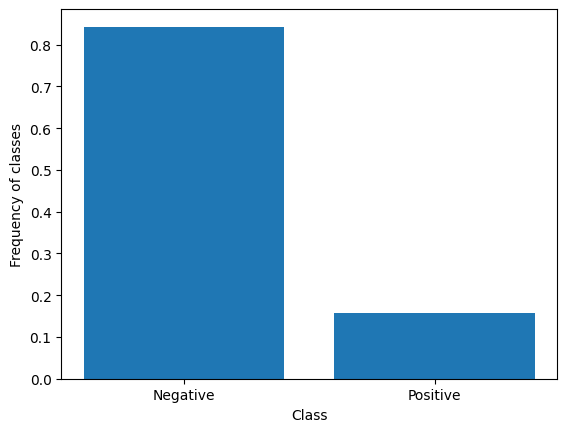

In [ ]:
plt.bar(["Negative", "Positive"], y.value_counts(normalize=True))
plt.title("")
plt.xlabel("Class")
plt.ylabel("Frequency of classes")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, fn_cost_train, fn_cost_test, fp_cost_train, fp_cost_test = train_test_split(
    data.drop("Churn", axis=1),
    y,
    fn_cost,
    fp_cost,
    test_size=0.25,
    random_state=0,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Zadanie 6 (1.5 punktu)**

1. Wytrenuj regresję logistyczną jako baseline, dokonując tuningu analogicznie do zadania 2. Pamiętaj o ustawieniu `random_state=0`. Zmierz czas treningu (włącznie z tuningiem). Sprawdź F1-score na zbiorze testowym
2. Wytrenuj liniowy SVM:
   - ustaw maksymalnie 10000 iteracji i zbalansowane wagi klas
   - dokonaj tuningu hiperparametru `C` za pomocą 5-krotnej walidacji skrośnej
   - sprawdź 100 wartości z zakresu od $10^{-2}$ do $10^2$
   - wypisz znalezioną optymalną wartość `C`
   - wybierz model o najwyższym F1-score
   - zmierz czas treningu (włącznie z tuningiem)
   - sprawdź F1-score na zbiorze testowym
   - pamiętaj o ustawieniu `random_state=0`

In [ ]:
baseline = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=0,
    penalty='l2',
    n_jobs=-1)

param_grid = {
    'C': np.logspace(-3, 3, num=100)
    }

grid_search_base = GridSearchCV(baseline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(f1_score))
start = time()
grid_search_base.fit(X_train_scaled, y_train)
stop = time()
print(f"Training time: {stop - start} s")

y_pred_base = grid_search_base.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred_base):.2f}%")

Training time: 16.482911109924316 s
F1-score: 61.40%


In [ ]:
param_grid = {
    'C': np.logspace(-2, 2, 100)
}

clf_linear_svc = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0,
    class_weight='balanced'
)

grid_search = GridSearchCV(clf_linear_svc, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
start = time()
grid_search.fit(X_train_scaled, y_train)
stop = time()
print("Best C:", grid_search.best_params_['C'])
print(f"Training time: {stop - start} s")

Best C: 57.223676593502205
Training time: 57.00287055969238 s


In [ ]:
best_lin = grid_search.best_estimator_

y_pred = best_lin.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 59.13%


**Zadanie 7 (2 punkty)**

1. Wytrenuj kernel SVM z domyślnymi hiperparametrami:
   - ustaw zbalansowane wagi klas

   - zmierz czas treningu (włącznie z tuningiem)  - TUTAJ BŁĄD CHYBA :)
  
   - sprawdź F1-score na zbiorze testowym
   - zmierz czas treningu
   - pamiętaj o ustawieniu `random_state=0`
2. Wytrenuj kernel SVM z tuningiem hiperparametrów:
   - sprawdź kilka siatek hiperparametrów (`param_grid` może być listą słowników!)
   - dla kerneli RBF sprawdź 20 wartości `C` z zakresu od $10^{-2}$ do $10^2$, a dla `gamma` sprawdź wartość `"scale"` oraz 20 wartości z zakresu od $10^{-2}$ do $10^2$
   - dla kernela wielomianowego sprawdź 100 wartości `C` z zakresu od $10^{-2}$ do $10^2$ oraz stopnie wielomianu z zakresu [2, 5]
   - dla kernela sigmoidalnego sprawdź te same zakresy wartości, co dla RBF
3. Dokonaj analizy hiperparametrów po tuningu:
   - sprawdź, dla jakich hiperparametrów osiągnięto najwyższy wynik walidacji skrośnej
   - sprawdź, jaki był najlepszy wynik osiągnięty dla każdego z trzech kerneli
   - wypisz hiperparametry dla każdego z tych przypadków
   - który kernel wymagał najmocniejszej regularyzacji i jak sądzisz, czemu ten?
   - wytrenuj SVM dla optymalnych hiperparametrów dla każdego z trzech kerneli i sprawdź F1-score na zbiorze testowym
   - czy udało się dobrze oszacować wynik za pomocą walidacji skrośnej, tj. czy faktycznie kernel o najwyższym wyniku walidacyjnym miał najwyższy wynik testowy?

In [ ]:
clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0
)
start_time = time()
clf_kernel_svc.fit(X_train_scaled, y_train)
end_time = time()
training_time = end_time - start_time

y_pred = clf_kernel_svc.predict(X_test_scaled)

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {training_time} s")

F1-score: 64.57%
Training time: 0.11369919776916504 s


In [ ]:
param_grid = [
    {'kernel': ['rbf'], 'C': np.logspace(-2, 2, 20), 'gamma': ['scale'] + list(np.logspace(-2, 2, 20))},
    {'kernel': ['poly'], 'C': np.logspace(-2, 2, 100), 'degree': [2, 3, 4, 5]},
    {'kernel': ['sigmoid'], 'C': np.logspace(-2, 2, 20), 'gamma': ['scale'] + list(np.logspace(-2, 2, 20))}
]

clf_kernel_svc_tuned = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0
)

grid_search = GridSearchCV(clf_kernel_svc_tuned, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

start = time()
grid_search.fit(X_train_scaled, y_train)
stop = time()

y_pred = grid_search.predict(X_test_scaled)

In [ ]:
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {stop - start} s")

F1-score: 87.69%
Training time: 902.1869556903839 s


In [ ]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 37.92690190732246, 'gamma': 0.4832930238571752, 'kernel': 'rbf'}


In [ ]:
rbf_best = 0
poly_best = 0
sigm_best = 0

rbf_params = {}
poly_params = {}
sigm_params = {}

for i in range(len(grid_search.cv_results_['mean_test_score'])):
  if grid_search.cv_results_['params'][i]['kernel'] == "rbf":
    if grid_search.cv_results_['mean_test_score'][i] > rbf_best:
      rbf_best = grid_search.cv_results_['mean_test_score'][i]
      rbf_params = grid_search.cv_results_['params'][i]
  if grid_search.cv_results_['params'][i]['kernel'] == "poly":
    if grid_search.cv_results_['mean_test_score'][i] > poly_best:
      poly_best = grid_search.cv_results_['mean_test_score'][i]
      poly_params = grid_search.cv_results_['params'][i]
  if grid_search.cv_results_['params'][i]['kernel'] == "sigmoid":
    if grid_search.cv_results_['mean_test_score'][i] > sigm_best:
      sigm_best = grid_search.cv_results_['mean_test_score'][i]
      sigm_params = grid_search.cv_results_['params'][i]


print(rbf_best, rbf_params)
print(poly_best, poly_params)
print(sigm_best, sigm_params)

0.8596082459631951 {'C': 37.92690190732246, 'gamma': 0.4832930238571752, 'kernel': 'rbf'}
0.8323483923483922 {'C': 91.11627561154896, 'degree': 5, 'kernel': 'poly'}
0.6586906824553976 {'C': 0.11288378916846889, 'gamma': 0.01, 'kernel': 'sigmoid'}


In [ ]:
clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    C=37.92690190732246,
    gamma=0.4832930238571752,
    kernel='rbf'
)
clf_kernel_svc.fit(X_train_scaled, y_train)
y_pred = clf_kernel_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 87.69%


In [ ]:
clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    C=91.11627561154896,
    degree=5,
    kernel='poly'
)
clf_kernel_svc.fit(X_train_scaled, y_train)
y_pred = clf_kernel_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 83.15%


In [ ]:
clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    C=0.11288378916846889,
    gamma=0.01,
    kernel='sigmoid'
)
clf_kernel_svc.fit(X_train_scaled, y_train)
y_pred = clf_kernel_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 60.00%


Sigmoid, ze względu na użytą funkcję której charaterystyka wymaga silnej regularyzacji, ponieważ jest podatna na overfitting. Widać też, że ten kernel dał najgorsze wyniki więc prawdopodobnie i tak bardzo się rozjeżdzał dla takich danych



Udało się dobrze oszacować wynik za pomocą walidacji skrośnej i kernel który uzyskał najlepsze wyniki ma najlepszy f1_score

Nie uwzględniliśmy jednak jeszcze faktu, że nasi klienci mają różną wagę. Według badań koszt zyskania klienta jest około 15 razy wyższy od kosztu utrzymania klienta, który jest zagrożony przejściem dla konkurencji. W związku z tym FP i FN mają różną ważnośc. Dodatkowo sami klienci płacą mniej lub więcej, więc to też trzeba uwzględnić. Na szczęście my mamy już to zrobione, bo mamy macierze `fp_cost` oraz `fn_cost` oznaczające koszt pomylenia się na oba sposoby w przypadku każdego klienta.

Powinniśmy zatem używać **ważonej metryki (weighted metric)**, która dla każdego przykładu stosuje odpowiednią wagę, i to w zależności od tego, w jaki sposób się pomyliliśmy. Tego typu metryki typowo działają jak funkcje kosztu - im mniejsza wartość, tym lepiej, bo często dosłownie reprezentują koszt, jaki firma musi ponieść przy stosowaniu danego algorytmu. Wykorzystanie takiej metryki to **cost-sensitive classification**.

**Zadanie 8 (0.5 punktu)**

1. Uzupełnij kod funkcji `churn_cost()`, która oblicza koszt dokonania danej klasyfikacji.
2. Stwórz funkcję w postaci akceptowanej przez `GridSearchCV` za pomocą `make_scorer`. Zwróć uwagę, żeby podać do niej prawidłowe argumenty.

In [ ]:
from typing import Union

from sklearn.metrics import make_scorer


def churn_cost(
    y_true: Union[np.ndarray, pd.Series],
    y_pred: Union[np.ndarray, pd.Series], 
    fp_cost: Union[np.ndarray, pd.Series], 
    fn_cost: Union[np.ndarray, pd.Series],
) -> float:
    # make sure all data is Numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fp_cost = np.array(fp_cost)
    fn_cost = np.array(fn_cost)
    
    # check which rows are for FP and FN
    fp = (y_true == 0) & (y_pred == 1)
    fn = (y_true == 1) & (y_pred == 0)
    
    
    # get costs for FP and FN
    fp_costs = np.sum(fp_cost[fp])
    fn_costs = np.sum(fn_cost[fn])
    
    # return sum of costs
    return fp_costs + fn_costs

churn_cost_score = make_scorer(
    churn_cost,
    greater_is_better=False, 
    needs_proba=False, 
    needs_threshold=False,
)

**Zadanie 9 (1 punkt)**

1. Wytrenuj klasyfikatory stały `DummyClassifier`:
   - taki, który zawsze przewiduje klasę negatywną (brak zmiany)
   - taki, który zawsze przewiduje klasę pozytywną (churn)
2. Sprawdź metrykę F1-score oraz nasz nowo zdefiniowany churn cost dla takich rozwiązań na zbiorze testowym. Wykorzystaj `fp_cost_test` oraz `fn_cost_test`.
3. Lepiej jest stosować reklamy dla wszystkich, czy po prostu zgodzić się na churn i nic z tym nie robić? Uwzględniając liczbę próbek w zbiorze testowym, czy twoim zdaniem wysoki koszt? Załóż, że walutą są dolary - irański rial zawsze był tak słabą walutą, że i tak używano walut zagranicznych, co widać też w tym zbiorze. Wartość każdego klienta jest typowo wysoka, bo to obliczona tzw. lifetime value - przewidywana potencjalna wartość klienta w przyszłości.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_negative = DummyClassifier(strategy='constant', constant=0)
dummy_positive = DummyClassifier(strategy='constant', constant=1)

dummy_negative.fit(X_train_scaled, y_train)
dummy_positive.fit(X_train_scaled, y_train)

DummyClassifier(constant=1, strategy='constant')

In [ ]:
y_pred_dummy_negative = dummy_negative.predict(X_test_scaled)
y_pred_dummy_positive = dummy_positive.predict(X_test_scaled)

f1_score_dummy_negative = f1_score(y_test, y_pred_dummy_negative)
f1_score_dummy_positive = f1_score(y_test, y_pred_dummy_positive)

churn_cost_dummy_negative = churn_cost(y_test, y_pred_dummy_negative, fp_cost_test, fn_cost_test)
churn_cost_dummy_positive = churn_cost(y_test, y_pred_dummy_positive, fp_cost_test, fn_cost_test)


print("F1-score for negative: {:.4f}".format(f1_score_dummy_negative))
print("F1-score for positive: {:.4f}".format(f1_score_dummy_positive))
print("Churn cost for negative: {:.2f}".format(churn_cost_dummy_negative))
print("Churn cost for positive: {:.2f}".format(churn_cost_dummy_positive))

F1-score for negative: 0.0000
F1-score for positive: 0.2719
Churn cost for negative: 15871.64
Churn cost for positive: 69593.20


In [ ]:
print(churn_cost_dummy_negative / len(y_test))
print(churn_cost_dummy_positive / len(y_test))

20.141680203045684
88.31624302030457


Bardziej opłaca się jak widać nie reklamować, niż reklamować u wszystkich, ponieważ jednak większość osób nie zmienia operatora i nawet wagi tak bardzo na to nie wpływają. Koszt względem ilości klientów nie jest chyba bardzo wysoki, ale nie jest też na tyle niski by nie opłacało się nie podjąć działań.

**Zadanie 10 (1 punkt)**

1. Wytrenuj liniowy SVM, wykorzystaj znalezioną wcześniej optymalną wartość `C`. Innych parametrów użyj tak, jak wcześniej. Jaki jest koszt przy wdrożeniu takiego rozwiązania? Ile zyskujemy względem najlepszego rozwiązania z poprzedniego zadania?
2. Wytrenuj kernel SVM, wykorzystaj znalezione wcześniej optymalne wartości hiperparametrów. Innych parametrów użyj tak, jak wcześniej. O ile lepszy jest koszt? O ile lepszy jest od modelu liniowego, jakim jest liniowy SVM?
3. Czy twoim zdaniem warto wdrażać rozwiązania oparte o ML do takich zadań?

In [ ]:
clf_linear_svc = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0,
    class_weight='balanced',
    C=57.223676593502205
)
clf_linear_svc.fit(X_train_scaled, y_train)
y_pred = clf_linear_svc.predict(X_test_scaled)
linear_churn_cost = churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test)

print("F1-score: {:.4f}".format(f1_score(y_test, y_pred)))
print("Churn cost: {:.2f}".format(linear_churn_cost))
print("Profit:")
print("from negative: {:.2f}".format(churn_cost_dummy_negative - linear_churn_cost))
print("from positive: {:.2f}".format(churn_cost_dummy_positive - linear_churn_cost))

F1-score: 0.5913
Churn cost: 11629.98
Profit:
from negative: 4241.67
from positive: 57963.22


In [ ]:
clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    C=37.92690190732246,
    gamma=0.4832930238571752,
    kernel='rbf'
)
clf_kernel_svc.fit(X_train_scaled, y_train)
y_pred = clf_kernel_svc.predict(X_test_scaled)
kernel_churn_cost = churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test)

print("F1-score: {:.4f}".format(f1_score(y_test, y_pred)))
print("Churn cost: {:.2f}".format(kernel_churn_cost))
print("Profit:")
print("from negative: {:.2f}".format(churn_cost_dummy_negative - kernel_churn_cost))
print("from positive: {:.2f}".format(churn_cost_dummy_positive - kernel_churn_cost))
print("from linear: {:.2f}".format(linear_churn_cost - kernel_churn_cost))

F1-score: 0.8769
Churn cost: 3920.36
Profit:
from negative: 11951.29
from positive: 65672.84
from linear: 7709.62


In [ ]:
print("Strata per klient dla braku działań: ", churn_cost_dummy_negative / len(y_test))
print("Strata per klient przy przewidywaniu z kernel: ", kernel_churn_cost / len(y_test))

Strata per klient dla braku działań:  20.141680203045684
Strata per klient przy przewidywaniu z kernel:  4.975071700507614


Zdecydowanie warto wdrażać takie rozwiązania, jak widać na powyższym przykładzie, zastosowanie modelu może dać oszczędność rzędu 75% względem braku podjęcia działań, i jeszcze więcej gdyby reklamy rozsyłać do wszystkich. Jest to bardzo duży zysk również bezwgędnie.

## Zadanie dodatkowe (3 punkty)

W przypadku, kiedy zastosowanie kernel SVM wprost byłoby zbyt kosztowne, można zamiast tego przybliżyć cechy kernelowe. Realizują to algorytmy grupy kernel approximation.

Metoda Nyströma to algorytm uniwersalny, który potrafi przybliżyć dowolny kernel. Wykorzystuje do tego truncated SVD, czyli przybliża wprost kernel matrix za pomocą macierzy niższej rangi. Ceną tej prostoty i uniwersalności jest nie najlepsza prędkość działania w porównaniu do bardziej specjalistycznych algorytmów. Proste wyprowadzenie tej metody można znaleźć [tutaj](https://stats.stackexchange.com/questions/261149/nystroem-method-for-kernel-approximation).

`RBFSampler` w Scikit-learn implementuje metodę Random Kitchen Sinks. Ten algorytm za pomocą próbkowania Monte Carlo przybliża coraz lepiej macierz kernela RBF. W bibliotece Scikit-learn-extra zaimplementowane jest rozwinięcie tego algorytmu o nazwie [Fastfood](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.kernel_approximation.Fastfood.html), który stosuje nieco bardziej zaawansowany algorytm przybliżający, który powinien być jeszcze szybszy i oszczędniejszy pamięciowo.

Hiperparametry tych metod są podobne do zwykłego kernel SVM, ale dodatkowo mamy wymiarowość naszego przybliżenia, czyli `n_components`. Im większe, tym dokładniej przybliżamy, ale też tym więcej mamy cech. Wejściem do metody Nyströma jest macierz cech X, a wyjściem macierz cech kernelowych X mająca rozmiar `n_samples * n_components`. Na takich cechach trenuje się już zwykły liniowy SVM.

1. Zaimplementuj `Pipeline` składający się z przybliżenia kernela oraz liniowego SVM: dla metody Nyströma, oraz dla obu algorytmów dla kernela RBF.
2. Wytrenuj algorytmy z domyślnymi hiperparametrami. Porównaj jakość predykcji oraz szybkość z liniowym SVM i z kernel SVM. Czy warto dokonać takiej aproksymacji?
3. Dokonaj optymalizacji hiperparametrów `C`, `gamma` oraz `n_components`. Czy udało się poprawić wynik względem zwykłego kernel SVM w rozsądnym czasie?

// skomentuj tutaj